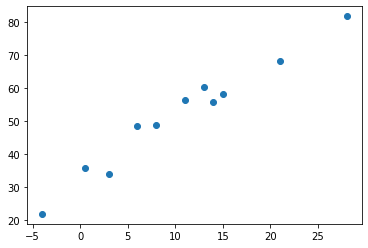

In [27]:
import torch

#magic function, plots will be visible in the notebook
%matplotlib inline

import matplotlib.pyplot as plt

#statement of the problem:
#we want to find the correlation between temperatures t_c and t_u. To be exact, we want to find the 
#transformation (possibly linear) that is needed to convert temp. units (t_u) to t_c.

# temperature data
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

plt.scatter(t_c, t_u)


In [90]:
# proceeding with the linear type of model (essentially defining linear regression from scratch)

#approach: we want to create a linear function that converts t_u to values t_p. t_p are meant
#to be the values as close to t_c as possible. w - weights, b - bias (y = w*x + b).

def model(t_u, w, b):
    return w * t_u + b

# we are applying the L2 kind of loss (MSE). More robust for outliers, penalizes very wrong results more that L1 metric.

def loss(t_p, t_c):
    loss = (t_p - t_c)**2
    return loss.mean()

#test
# test_c = torch.tensor([2], dtype = float)
# test_p = torch.tensor([1], dtype = float)

# print(loss(test_c, test_p))

# w and b initializing
w = torch.ones(())
b = torch.zeros(())

# calculating t_p for earlier defined t_u

t_p = model(t_u, w, b)
loss(t_p, t_c)


tensor(1763.8846)

In [84]:
# BROADCASTING
# pytorch functionality that allow us to perform operations of tensors that are not necessarily of the same size/shape.

x = torch.ones(())
y = torch.ones(3,1,1,1,1)
z = torch.ones(1,3)
a = torch.ones(2,1,1)

print(f"Shapes of the tensors: x - {x.shape}, y - {y.shape})")
print(f"Shapes of the tensors: z - {z.shape}, a - {a.shape})")
print(f"Shapes of the tensors: y*a - {(y*a).shape}")
print(f"Shapes of the tensors: a*z - {(a*z).shape}")
print(f"Shapes of the tensors: y*a*z - {(y*a*z).shape}")


Shapes of the tensors: x - torch.Size([]), y - torch.Size([3, 1, 1, 1, 1]))
Shapes of the tensors: z - torch.Size([1, 3]), a - torch.Size([2, 1, 1]))
Shapes of the tensors: y*a - torch.Size([3, 1, 2, 1, 1])
Shapes of the tensors: a*z - torch.Size([2, 1, 3])
Shapes of the tensors: y*a*z - torch.Size([3, 1, 2, 1, 3])


In [83]:
# rate of change calculating

delta = 0.1
loss_rate_of_change_w = (model(t_u, w + delta, b) - model(t_u, w - delta, b))/(2*delta)
print(loss_rate_of_change_w)
print(loss_rate_of_change_w.mean())

#same calculating for the b parameter
loss_rate_of_change_b = (model(t_u, w, b + delta) - model(t_u, w, b - delta))/(2*delta)
print(loss_rate_of_change_b)
print(loss_rate_of_change_b.mean())

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])
tensor(51.8000)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000])
tensor(1.0000)


In [103]:
#derivatives for the gradient descent

#first, derivative of the loss function (which is a quadratic function, MSE)
#remembering that t_p is the the variable here
def dloss(t_p, t_c):
    dloss = 2*(t_p - t_c)
    return dloss / t_p.size(0) #division necessary to address the mean calculation from the model

#second, derivative of the model function (linear)

#two variables here, w and b, so two functions
def dmodel_dw(t_u, w, b):
    return t_u

def dmodel_db(t_u, w, b):
    return 1.0

#calculating the whole gradient in the one function (the loss function derivative in regard to w and b parameters)
def grad(t_u, t_c, t_p, w, b):
    dloss_dtp = dloss(t_p, t_c)
    
    #chain rule
    dloss_dw = dloss_dtp * dmodel_dw(t_u, w ,b)
    dloss_db = dloss_dtp * dmodel_db(t_u, w ,b)
    
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])
    
grad(t_u, t_c, t_p, w, b)

tensor([4517.2969,   82.6000])

In [159]:
#creating the whole training loop (iterating the gradient calculation and applying it to the model parameters)

def training_loop(n_epochs, learning_rate, model_params, t_u, t_c, do_print = True):
    
    for i in range(1, n_epochs+1):
        w, b = model_params
        t_p = model(t_u, w, b) #first, model value
        model_loss = loss(t_p, t_c) #second, loss value, to print it and look if it is going down
        grad_value = grad(t_u, t_c, t_p, w, b) #third, gradient calculation
        
        model_params = model_params - learning_rate * grad_value #fourth, update the parameters
        
        if i in [1,2,3,n_epochs, n_epochs-1, n_epochs-2] and do_print == True:

            print(f"Epoch: {i}, Loss value: {model_loss}")
            print(f"Params values: w = {model_params[0]}, b = {model_params[1]}")
            print(f"Gradient value: {grad_value}")
        
    
    return model_params

initial_params = torch.tensor([1.0, 0.0])
        
training_loop(15, 1e-2, initial_params, t_u, t_c)        

Epoch: 1, Loss value: 1763.8846435546875
Params values: w = -44.17296600341797, b = -0.8259999752044678
Gradient value: tensor([4517.2969,   82.6000])
Epoch: 2, Loss value: 5802485.5
Params values: w = 2568.4013671875, b = 45.16371154785156
Gradient value: tensor([-261257.4219,   -4598.9712])
Epoch: 3, Loss value: 19408035840.0
Params values: w = -148527.734375, b = -2616.393310546875
Gradient value: tensor([15109614.0000,   266155.7188])
Epoch: 13, Loss value: inf
Params values: w = -6.218085327793313e+22, b = -1.0953026620805014e+21
Gradient value: tensor([6.3256e+24, 1.1142e+23])
Epoch: 14, Loss value: inf
Params values: w = 3.5961806514938787e+24, b = 6.334596602673127e+22
Gradient value: tensor([-3.6584e+26, -6.4441e+24])
Epoch: 15, Loss value: inf
Params values: w = -2.0798228017110418e+26, b = -3.6635645899825066e+24
Gradient value: tensor([2.1158e+28, 3.7269e+26])


tensor([-2.0798e+26, -3.6636e+24])

In [139]:
#the values are diverging instead of converging - possibly the result of too big learning rate. updating to 1e-5
training_loop(100, 1e-5, initial_params, t_u, t_c)       

Epoch: 1, Loss value: 1763.8846435546875
Params values: w = 0.9548270106315613, b = -0.0008259999449364841
Gradient value: tensor([4517.2969,   82.6000])
Epoch: 2, Loss value: 1565.7613525390625
Params values: w = 0.9123117923736572, b = -0.0016051840502768755
Gradient value: tensor([4251.5215,   77.9184])
Epoch: 3, Loss value: 1390.2655029296875
Params values: w = 0.8722979426383972, b = -0.002340306993573904
Gradient value: tensor([4001.3838,   73.5123])
Epoch: 98, Loss value: 29.117908477783203
Params values: w = 0.23425845801830292, b = -0.016456322744488716
Gradient value: tensor([12.5503,  3.2493])
Epoch: 99, Loss value: 29.11627960205078
Params values: w = 0.23414036631584167, b = -0.016488686203956604
Gradient value: tensor([11.8088,  3.2363])
Epoch: 100, Loss value: 29.114818572998047
Params values: w = 0.23402926325798035, b = -0.016520926728844643
Gradient value: tensor([11.1109,  3.2240])


tensor([ 0.2340, -0.0165])

In [140]:
#loss function stops converging. looking at the gradient it seems that the parameters of the model are of a different scale;
#the one learning rate cannot effectively converge both parameters. better solution - normalize the inputs.

print(t_u)
t_un = t_u * 1e-1 #defining normalized version
print(t_un)  

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])
tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])


In [143]:
#running same loop again with normalized t_u, going back to learning rate of 1e-2 (seems better), more epochs.
training_loop(5000, 1e-2, initial_params, t_un, t_c) 

Epoch: 1, Loss value: 80.36434173583984
Params values: w = 1.7761403322219849, b = 0.10639999061822891
Gradient value: tensor([-77.6140, -10.6400])
Epoch: 2, Loss value: 37.57491683959961
Params values: w = 2.084763288497925, b = 0.13026385009288788
Gradient value: tensor([-30.8623,  -2.3864])
Epoch: 3, Loss value: 30.871076583862305
Params values: w = 2.2093942165374756, b = 0.12167707830667496
Gradient value: tensor([-12.4631,   0.8587])
Epoch: 4998, Loss value: 2.9276468753814697
Params values: w = 5.367081642150879, b = -17.301177978515625
Gradient value: tensor([-0.0001,  0.0006])
Epoch: 4999, Loss value: 2.927647352218628
Params values: w = 5.367082595825195, b = -17.301183700561523
Gradient value: tensor([-0.0001,  0.0006])
Epoch: 5000, Loss value: 2.927647590637207
Params values: w = 5.367083549499512, b = -17.301189422607422
Gradient value: tensor([-0.0001,  0.0006])


tensor([  5.3671, -17.3012])

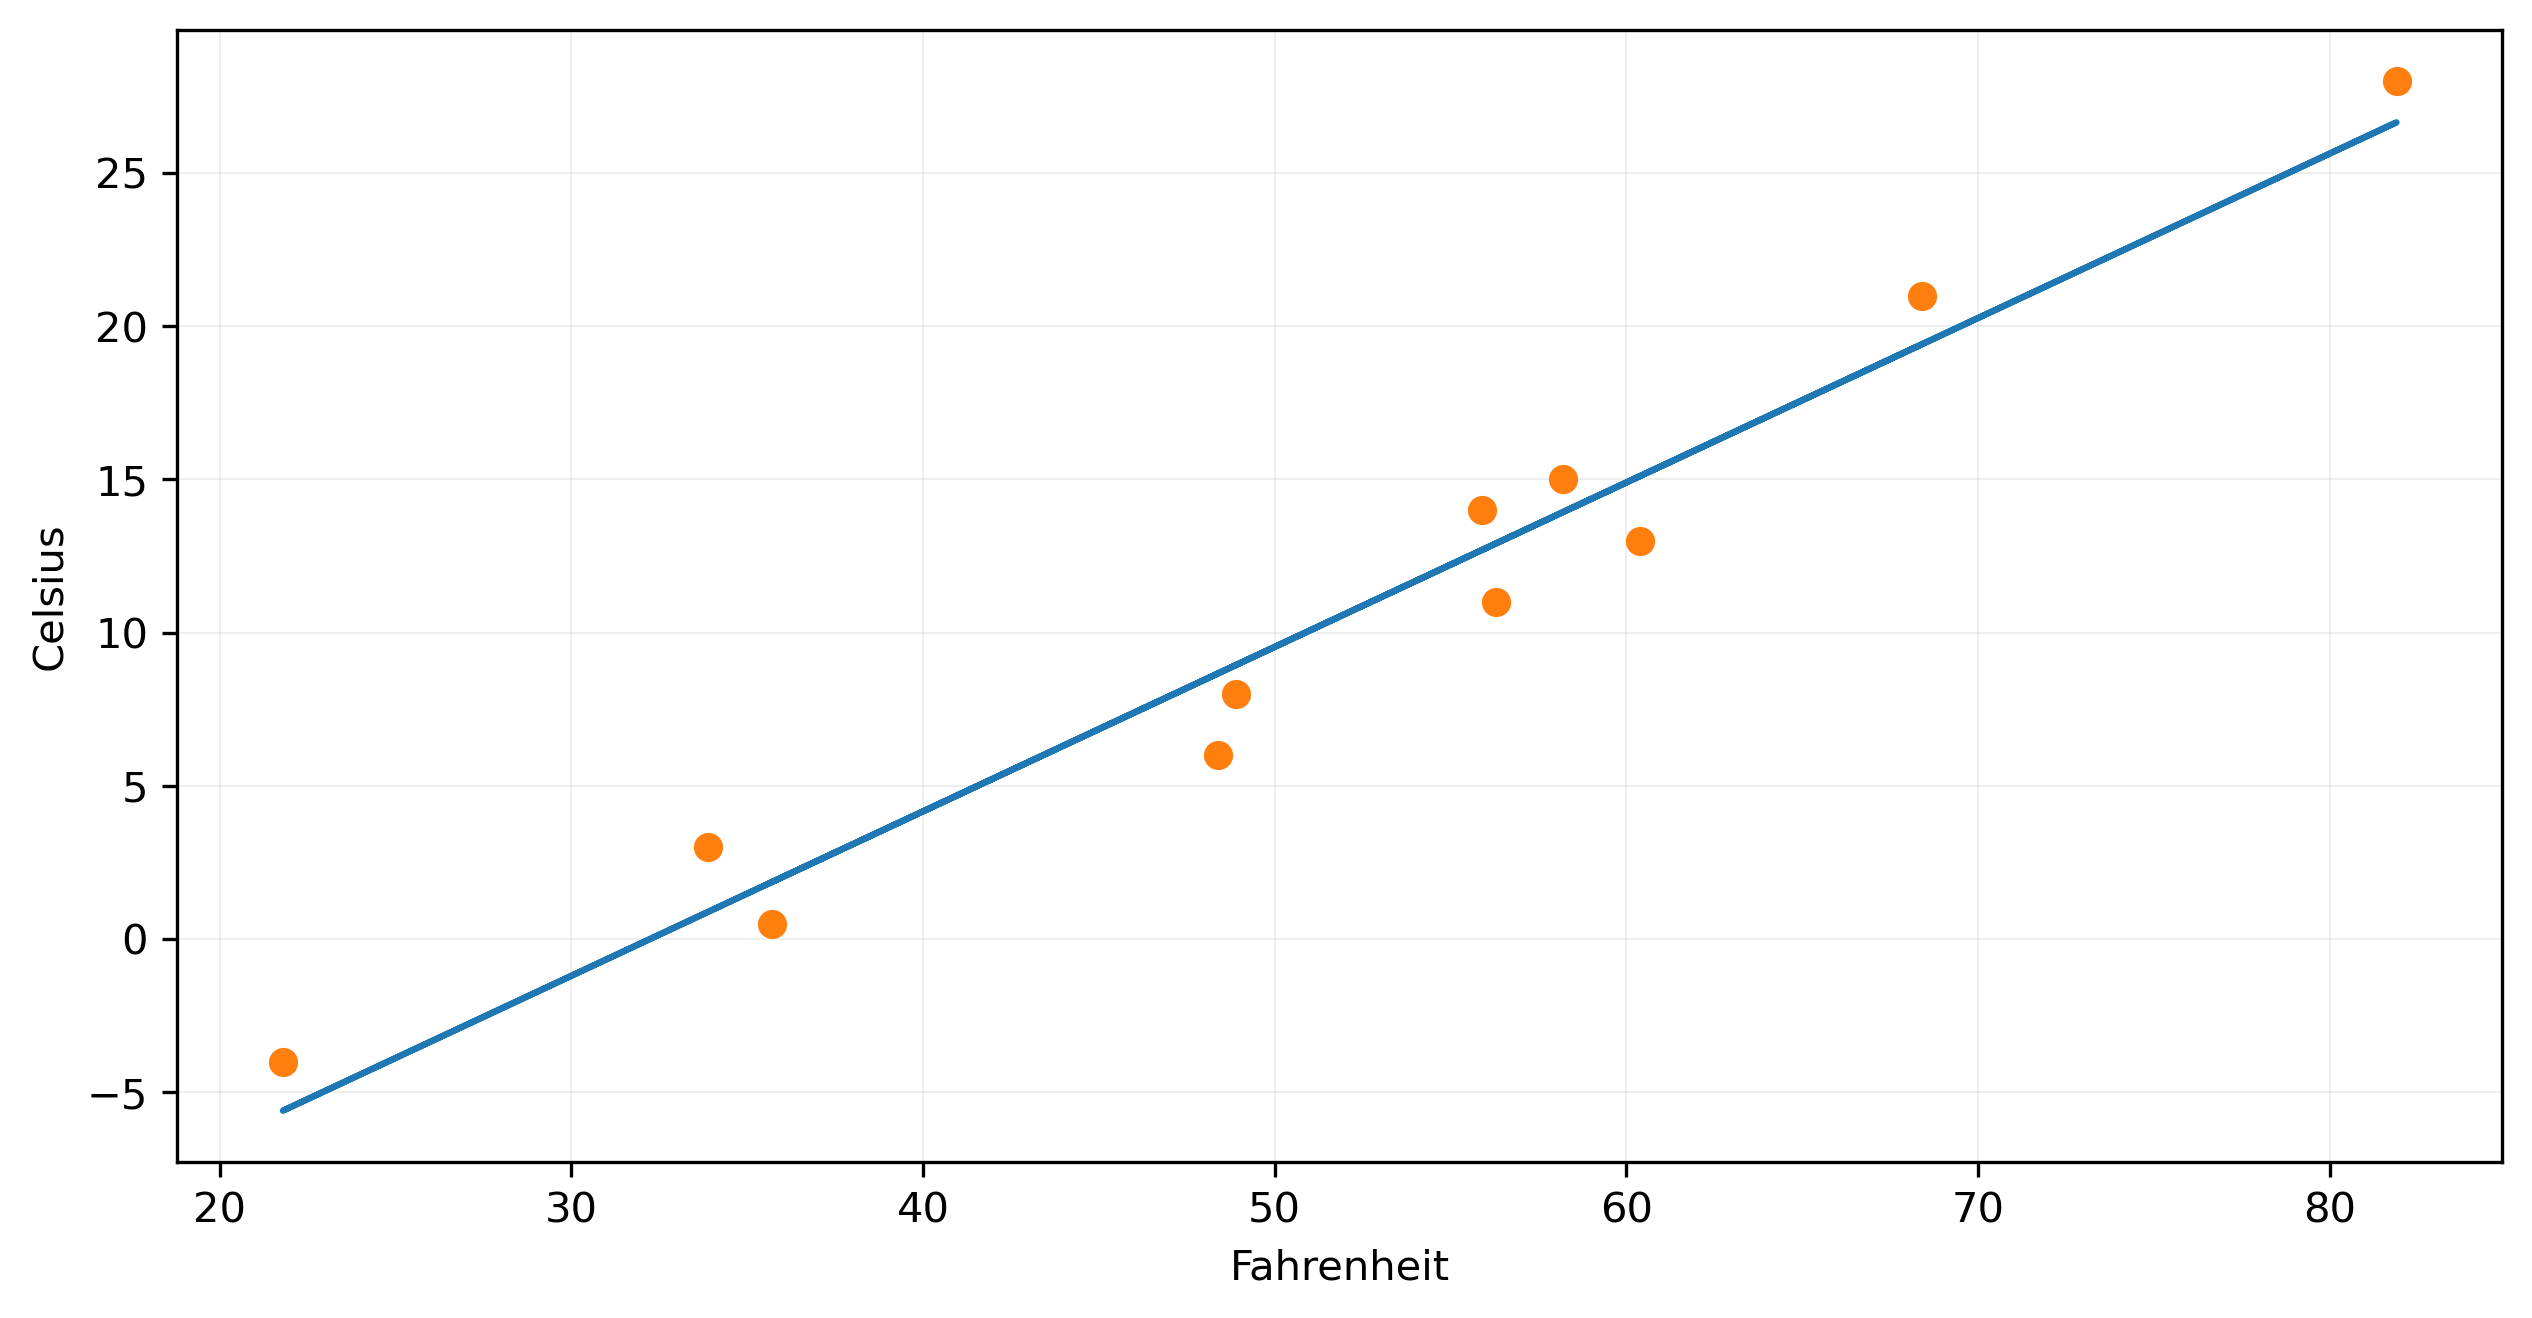

In [179]:
#good enough approximation, the data isn't perfectly linear, error won't converge to 0.
#take the parameters and make the final model

final_params = training_loop(5000, 1e-2, initial_params, t_un, t_c, do_print = False) 
t_p = model(t_un, *final_params)

#visualizing!

fig = plt.figure(dpi = 300, figsize = (10,5))
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u, t_p)
plt.plot(t_u, t_c, 'o')
plt.grid(linewidth = 0.1)

In [231]:
#rewriting to use the autograd functionality
params = torch.tensor([1., 0.], requires_grad = True)


#performin the backward pass. this tracks the derivative part of previous code.
loss_wg = loss(model(t_u, *params), t_c)
loss_wg.backward()

params.grad

tensor([4517.2969,   82.6000])

In [236]:
#updating the iteration loop function to include the backward pass
def training_loop_wg(n_epochs, learning_rate, params, t_u, t_c, do_print = True):
    
    for i in range(1, n_epochs+1):
        t_p = model(t_u, *params) #first, model value
        model_loss = loss(t_p, t_c) #second, loss value, to print it and look if it is going down
        model_loss.backward()
#         grad_value = grad(t_u, t_c, t_p, w, b) #we are no longer using the manual grad calculation 
                                                #(the backward loss pass is doing the job for us)
        
        with torch.no_grad():
            params -= learning_rate * params.grad
            
        params.grad.zero_()
        
        if i in [1,2,3,n_epochs, n_epochs-1, n_epochs-2] and do_print == True:

            print(f"Epoch: {i}, Loss value: {model_loss}")
            print(f"Params values: w = {params[0]}, b = {params[1]}")
#             print(f"Gradient value: {grad_value}")
        
    
    return params

params = torch.tensor([1., 0.], requires_grad = True)
training_loop_wg(5000, 1e-2, params, t_un, t_c, do_print = True)
params

Epoch: 1, Loss value: 80.36434173583984
Params values: w = 1.7761403322219849, b = 0.10639999061822891
Epoch: 2, Loss value: 37.57491683959961
Params values: w = 2.084763288497925, b = 0.13026385009288788
Epoch: 3, Loss value: 30.871076583862305
Params values: w = 2.2093942165374756, b = 0.12167707830667496
Epoch: 4998, Loss value: 2.9276466369628906
Params values: w = 5.367082595825195, b = -17.30118179321289
Epoch: 4999, Loss value: 2.927647590637207
Params values: w = 5.367083549499512, b = -17.30118751525879
Epoch: 5000, Loss value: 2.9276468753814697
Params values: w = 5.367084503173828, b = -17.301193237304688


tensor([  5.3671, -17.3012], requires_grad=True)

In [237]:
#adding the optimizer
def training_loop_wo(n_epochs, learning_rate, params, t_u, t_c, do_print = True):
    
    #first, setting up the optimizer and passing the params inside
    #for starters, the regular SGD optimizer
    
    import torch.optim as optim
    optimizer = optim.SGD([params], lr = learning_rate) #passing the params and learning rate
    
    for i in range(1, n_epochs+1):
        t_p = model(t_u, *params) #first, model value
        model_loss = loss(t_p, t_c) #second, loss value, to print it and look if it is going down
        model_loss.backward()
#         grad_value = grad(t_u, t_c, t_p, w, b) #we are no longer using the manual grad calculation 
                                                #(the backward loss pass is doing the job for us)
        
#         with torch.no_grad():
#             params -= learning_rate * params.grad #this part of the code also becomes obsolete since we now have our
                                                    #optimizer ready to do the job
        
        optimizer.step() #this one updates the params values
        optimizer.zero_grad()
#         params.grad.zero_() #also redundant, we are using the above line for that
        
        if i in [1,2,3,n_epochs, n_epochs-1, n_epochs-2] and do_print == True:

            print(f"Epoch: {i}, Loss value: {model_loss}")
            print(f"Params values: w = {params[0]}, b = {params[1]}")
#             print(f"Gradient value: {grad_value}")
        
    
    return params

params = torch.tensor([1., 0.], requires_grad = True)
training_loop_wo(5000, 1e-2, params, t_un, t_c, do_print = True)
params

Epoch: 1, Loss value: 80.36434173583984
Params values: w = 1.7761403322219849, b = 0.10639999061822891
Epoch: 2, Loss value: 37.57491683959961
Params values: w = 2.084763288497925, b = 0.13026385009288788
Epoch: 3, Loss value: 30.871076583862305
Params values: w = 2.2093942165374756, b = 0.12167707830667496
Epoch: 4998, Loss value: 2.9276466369628906
Params values: w = 5.367082595825195, b = -17.30118179321289
Epoch: 4999, Loss value: 2.927647590637207
Params values: w = 5.367083549499512, b = -17.30118751525879
Epoch: 5000, Loss value: 2.9276468753814697
Params values: w = 5.367084503173828, b = -17.301193237304688


tensor([  5.3671, -17.3012], requires_grad=True)

In [241]:
#experimenting with ADAM optimizer
#adding the optimizer
def training_loop_w_Adam(n_epochs, learning_rate, params, t_u, t_c, do_print = True):
    
    #first, setting up the optimizer and passing the params inside
    #for starters, the regular SGD optimizer
    
    import torch.optim as optim
    optimizer = optim.Adam([params], lr = learning_rate) #passing the params and learning rate
    
    for i in range(1, n_epochs+1):
        t_p = model(t_u, *params) #first, model value
        model_loss = loss(t_p, t_c) #second, loss value, to print it and look if it is going down
        model_loss.backward()
#         grad_value = grad(t_u, t_c, t_p, w, b) #we are no longer using the manual grad calculation 
                                                #(the backward loss pass is doing the job for us)
        
#         with torch.no_grad():
#             params -= learning_rate * params.grad #this part of the code also becomes obsolete since we now have our
                                                    #optimizer ready to do the job
        
        optimizer.step() #this one updates the params values
        optimizer.zero_grad()
#         params.grad.zero_() #also redundant, we are using the above line for that
        
        if i in [1,2,3,n_epochs, n_epochs-1, n_epochs-2] and do_print == True:

            print(f"Epoch: {i}, Loss value: {model_loss}")
            print(f"Params values: w = {params[0]}, b = {params[1]}")
#             print(f"Gradient value: {grad_value}")
        
    
    return params

#also changing the inputs
#since ADAM is less scale sensitive, we are using old t_u (unnormalized input), we can also go back to
#higher learning rate (it is adaptive) and do less epochs
params = torch.tensor([1., 0.], requires_grad = True)
training_loop_w_Adam(2000, 1e-1, params, t_u, t_c, do_print = True)
params


Epoch: 1, Loss value: 1763.8846435546875
Params values: w = 0.8999999761581421, b = -0.09999999403953552
Epoch: 2, Loss value: 1334.34912109375
Params values: w = 0.8006196618080139, b = -0.19941246509552002
Epoch: 3, Loss value: 967.8158569335938
Params values: w = 0.7024322152137756, b = -0.29770106077194214
Epoch: 1998, Loss value: 2.9276466369628906
Params values: w = 0.5367231369018555, b = -17.30201530456543
Epoch: 1999, Loss value: 2.927645206451416
Params values: w = 0.5367234945297241, b = -17.302038192749023
Epoch: 2000, Loss value: 2.9276459217071533
Params values: w = 0.5367238521575928, b = -17.302061080932617


tensor([  0.5367, -17.3021], requires_grad=True)